In [23]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, classification_report, balanced_accuracy_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras 
from keras import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [25]:
def saveModel(model, filename):
    model.save(filename)

def loadModel(filename):
    model = joblib.load(filename)
    return model

In [26]:
df = pd.read_csv("../data/[CLEANED]kepler-data.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)

In [27]:
ALL_COLUMNS = df.columns
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
EXCLUDE = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"] + ERROR_COLUMNS
TO_USE = list(set(ALL_COLUMNS) - set(EXCLUDE))

In [28]:
subset_df = df[df["koi_disposition"] != "CANDIDATE"]

In [29]:
X = subset_df[TO_USE].values
y = subset_df["koi_disposition"].apply(lambda x: x=='CONFIRMED').astype(int).values

In [30]:
X = StandardScaler().fit_transform(X)
#X = PCA().fit_transform(X)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0, stratify=y)

In [32]:
def createModel():
    model = Sequential([
                    Dense(256, input_dim=X.shape[1], activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
                   ])
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [33]:
def performance(test, pred):
    conf_matrix = confusion_matrix(test, pred)
    f1 = f1_score(test, pred)
    report = classification_report(test, pred)
    accuracy = balanced_accuracy_score(test, pred)
    kappa = cohen_kappa_score(test, pred)
    print(f"F1 Score: {f1}")
    print(f"Kappa Score: {kappa}")
    print(f"Accuracy Score: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(report)

In [34]:
def trainEvaluate(model, fold, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, epochs=20, verbose=0)
    pred = model.predict(X_test)
    pred = pred >= 0.5
    f1 = f1_score(y_test, pred)
    print(f"F1 Score in fold {fold} = {f1}")
    return f1

def crossValidation(K=10):
    kFold = KFold(n_splits=K, shuffle=True, random_state=0)
    f1_scores = list()
    k_ctr = 1
    for train, test in kFold.split(X, y):
        model = None
        model = createModel()
        current_f1 = trainEvaluate(model, k_ctr, X[train], y[train], X[test], y[test])
        f1_scores.append(current_f1)
        k_ctr+=1
    print(f"Average {K}-Fold F1 Score = {np.mean(f1_scores)}\n")
    
    k_ctr = 1
    kFold = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)
    f1_scores = list()
    for train, test in kFold.split(X, y):
        model = None
        model = createModel()
        current_f1 = trainEvaluate(model, k_ctr, X[train], y[train], X[test], y[test])
        f1_scores.append(current_f1)
        k_ctr+=1
    print(f"Average Stratified {K}-Fold F1 Score = {np.mean(f1_scores)}")

In [35]:
crossValidation(K=10)

F1 Score in fold 1 = 0.9752808988764045
F1 Score in fold 2 = 0.9722222222222222
F1 Score in fold 3 = 0.9639639639639639
F1 Score in fold 4 = 0.9733333333333334
F1 Score in fold 5 = 0.963302752293578
F1 Score in fold 6 = 0.9855670103092784
F1 Score in fold 7 = 0.9812889812889812
F1 Score in fold 8 = 0.9700854700854702
F1 Score in fold 9 = 0.9836734693877551
F1 Score in fold 10 = 0.9730941704035874
Average 10-Fold F1 Score = 0.9741812272164575

F1 Score in fold 1 = 0.9848156182212582
F1 Score in fold 2 = 0.982532751091703
F1 Score in fold 3 = 0.9574944071588367
F1 Score in fold 4 = 0.9610389610389611
F1 Score in fold 5 = 0.9781659388646288
F1 Score in fold 6 = 0.9847494553376905
F1 Score in fold 7 = 0.9780701754385964
F1 Score in fold 8 = 0.9634408602150538
F1 Score in fold 9 = 0.9802197802197802
F1 Score in fold 10 = 0.9691629955947135
Average Stratified 10-Fold F1 Score = 0.9739690943181222


In [36]:
model = createModel()
model.fit(X_train, y_train, epochs=20, verbose=0)
pred = model.predict(X_test)
pred = pred >= 0.5

In [37]:
performance(y_test, pred)

F1 Score: 0.9774834437086093
Kappa Score: 0.9664085541268381
Accuracy Score: 0.9828801142360464
Confusion Matrix:
[[1518   16]
 [  18  738]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1534
           1       0.98      0.98      0.98       756

    accuracy                           0.99      2290
   macro avg       0.98      0.98      0.98      2290
weighted avg       0.99      0.99      0.99      2290



In [38]:
saveModel(model, "../model/nn-model.h5")

In [39]:
model_perm = KerasClassifier(build_fn=createModel, epochs=20, verbose=0)
model_perm.fit(X, y)
perm = PermutationImportance(model_perm, random_state=0).fit(X,y)

In [40]:
eli5.explain_weights(perm, feature_names = TO_USE)

Weight,Feature
0.1318 ± 0.0078,koi_fpflag_ss
0.1277 ± 0.0044,koi_fpflag_co
0.1020 ± 0.0025,koi_fpflag_nt
0.0637 ± 0.0025,koi_fpflag_ec
0.0523 ± 0.0026,koi_depth
0.0449 ± 0.0032,koi_period
0.0433 ± 0.0045,koi_duration
0.0402 ± 0.0021,koi_teq
0.0211 ± 0.0021,koi_slogg
0.0191 ± 0.0030,koi_steff


In [41]:
perm.feature_importances_

array([0.00123936, 0.12765527, 0.05231299, 0.04023631, 0.00351633,
       0.04487675, 0.00230578, 0.00446749, 0.01905172, 0.00089347,
       0.0432627 , 0.13183454, 0.06369791, 0.00046111, 0.10203196,
       0.00371809, 0.00489981, 0.00873322, 0.0210693 ])

In [42]:
order = np.argsort(perm.feature_importances_)[::-1]
sorted_importances = sorted(perm.feature_importances_, reverse = True)
sorted_features = np.asarray(TO_USE)[order]
feature_importance_df = pd.DataFrame()
feature_importance_df['Features'] = sorted_features
feature_importance_df['Importance'] = np.asarray(sorted_importances)

In [43]:
feature_importance_df.head()

,Features,Importance
0,koi_fpflag_ss,0.131835
1,koi_fpflag_co,0.127655
2,koi_fpflag_nt,0.102032
3,koi_fpflag_ec,0.063698
4,koi_depth,0.052313


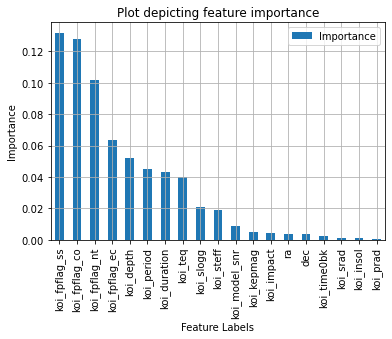

In [44]:
feature_importance_df.plot(x = 'Features', y = 'Importance', kind = 'bar')
plt.title('Plot depicting feature importance')
plt.xlabel('Feature Labels')
plt.ylabel("Importance")
plt.grid()
plt.show()